In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import math
import netCDF4
from kolzur_filter import kz_filter, kzft, kzp, _kz_coeffs
subplot_matrix = []

In [2]:
filelist = ['Eastern', 'Tap Mun', 'Tsuen Wan', 'Tung Chung', 'Yuen Long', 'Kwai Chung', 'Kwun Tong', 'Macau', 'Sha Tin', 'ShamShuiPo']

In [3]:
variablelist = ['Pressure', 'RH', 'Temperature', 'Wind']
sheetlist = ['ps', 'rh', 'temperature', 'ws']

In [4]:
# Experiments
# rcp26, rcp45, rcp60, rcp85
exp1 = 'rcp26'
exp2 = 'rcp45'
exp3 = 'rcp60'
exp4 = 'rcp85'
explist = [exp1, exp2, exp3, exp4]

In [5]:
# Set the directory
directory = "Future Regression/"
if not os.path.exists(directory):
    os.makedirs(directory)

In [6]:
# Import regression coefficients
directory_import_regression = "Regression Coefficients/"

In [22]:
def future_regression(station, exp):
    if station == 'Tap Mun':
        return
    m = 29
    k = 3
    w = int(k * (m - 1) / 2)
    
    pressure = []
    rh = []
    temperature = []
    wind = []
    timestamp = []
    timestamp_2013 = []
    pressure0 = []
    rh0 = []
    temperature0 = []
    wind0 = []
    header = [pressure, rh, temperature, wind]
    header0 = [pressure0, rh0, temperature0, wind0]
    
    # Import Model Combine
    for i in range(len(header)):
        var = variablelist[i]
        title = exp + '_' + var
        sheet = exp + '_' + sheetlist[i]
        A = pd.read_excel(open('Model Combine/' + exp + '/' + title + '.xlsx', 'rb'), sheet_name=sheet)
        B = pd.read_excel(open('Model Combine/' + exp + '/' + title + '.xlsx', 'rb'), sheet_name='2013-2017')
        A = np.array(A)
        B = np.array(B)
        for v in range(len(A)):
            add = A[v][-1]
            time = A[v][0]
            if i == 0:
                timestamp.append(time)
            header[i].append(add)
        for y in range(len(B)):
            add2 = B[y][-1]
            time2 = B[y][0]
            if i == 0:
                timestamp_2013.append(time2)
            header0[i].append(add2)

            
    print(station, len(pressure), len(rh), len(temperature), len(wind), len(timestamp))
    
    # Import regression coefficients
    read = directory_import_regression + station + '.csv'
    coefficients = pd.read_csv(directory_import_regression + station + '.csv', 'r', header=None)
    coefficients = np.array(coefficients)
    coeff = coefficients[0][0]
    intercept = float(coeff.split(',')[0])
    beta_ps = float(coeff.split(',')[1])
    beta_rh = float(coeff.split(',')[2])
    beta_t = float(coeff.split(',')[3])
    beta_ws = float(coeff.split(',')[4])
    
    print('Regression Coefficients:', round(intercept,4), round(beta_ps,4), round(beta_rh,4), round(beta_t,4), round(beta_ws, 4))
    
    # 2013-2017
    timestamp_2013 = timestamp_2013[w:-w]
    pressure0 = np.asfarray(pressure0, float)
    rh0 = np.asfarray(rh0, float)
    temperature0 = np.asfarray(temperature0, float)
    wind0 = np.asfarray(wind0, float)
    
    # KZ Filter
    pressure0 = kz_filter(pressure0, m, k)
    rh0 = kz_filter(rh0, m, k)
    temperature0 = kz_filter(temperature0, m, k)
    wind0 = kz_filter(wind0, m, k)
    
    y0 = []
    for t in range(len(timestamp_2013)):
        yhat = intercept + beta_ps*float(pressure0[t]) + beta_rh*float(rh0[t]) + beta_t*float(temperature0[t]) + beta_ws*float(wind0[t])
        y0.append(yhat)
        
        
    #fig = plt.figure()  # Create a figure
    #ax = plt.axes()  # Create axis
    #ax.grid(True)
    #plt.plot(timestamp_2013, y0, label='O3_BL')
    #ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # Set Maximum number of x-axis values to show
    #fig.autofmt_xdate()  # Rotate values to see more clearly
    #plt.legend(loc='best')
    #title = station + ' 2013-2017'
    #plt.title(title)
    #plt.ylabel("ln(ppb)")
    #fig.savefig(directory + station + ' 2013-2017'+ ".png")
    
    
    
    # 2045-2050
    cut1 = 0
    year = int(timestamp[cut1].year)
    while(year < 2046):
        year = int(timestamp[cut1].year)
        cut1 += 1
    cut1 -= 1
    cut2 = cut1
    while(year < 2051):
        year = int(timestamp[cut2].year)
        cut2 += 1
    cut2 -= 1
    timestamp1 = timestamp[cut1:cut2]
    pressure1 = np.array(pressure[cut1:cut2])
    rh1 = np.array(rh[cut1:cut2])
    temperature1 = np.array(temperature[cut1:cut2])
    wind1 = np.array(wind[cut1:cut2])
    
    
    timestamp1 = timestamp1[w:-w]
    pressure1 = np.asfarray(pressure1, float)
    rh1 = np.asfarray(rh1, float)
    temperature1 = np.asfarray(temperature1, float)
    wind1 = np.asfarray(wind1, float)
    
    # KZ Filter
    pressure1 = kz_filter(pressure1, m, k)
    rh1 = kz_filter(rh1, m, k)
    temperature1 = kz_filter(temperature1, m, k)
    wind1 = kz_filter(wind1, m, k)
    
    # calculate the difference of Temp, RH, pressure, wind speed 
    # between [(2045-2050) and (2013-2017)] 
    diff_pressure = (pressure1-pressure0)
    diff_rh = (rh1-rh0)
    diff_temperature = (temperature1-temperature0)
    diff_wind = (wind1-wind0)
    
    y1 = []
    y1_new = []
    jan1 = []
    feb1 = []
    mar1 = []
    apr1 = []
    may1 = []
    jun1 = []
    jul1 = []
    aug1 = []
    sep1 = []
    ocb1 = []
    nov1 = []
    dec1 = []
    
    for t in range(len(timestamp1)):
        yhat = intercept + beta_ps*float(pressure1[t]) + beta_rh*float(rh1[t]) + beta_t*float(temperature1[t]) + beta_ws*float(wind1[t])
        yhat_new = yhat + beta_ps*float(diff_pressure[t]) + beta_rh*float(diff_rh[t]) + beta_t*float(diff_temperature[t]) + beta_ws*float(diff_wind[t])
        y1.append(yhat)
        y1_new.append(yhat_new)
        if int(timestamp1[t].month) == 1:
            jan1.append(math.exp(yhat_new))
        if int(timestamp1[t].month) == 2:
            feb1.append(math.exp(yhat_new))
        if int(timestamp1[t].month) == 3:
            mar1.append(math.exp(yhat_new))
        if int(timestamp1[t].month) == 4:
            apr1.append(math.exp(yhat_new))
        if int(timestamp1[t].month) == 5:
            may1.append(math.exp(yhat_new))
        if int(timestamp1[t].month) == 6:
            jun1.append(math.exp(yhat_new))
        if int(timestamp1[t].month) == 7:
            jul1.append(math.exp(yhat_new))
        if int(timestamp1[t].month) == 8:
            aug1.append(math.exp(yhat_new))
        if int(timestamp1[t].month) == 9:
            sep1.append(math.exp(yhat_new))
        if int(timestamp1[t].month) == 10:
            ocb1.append(math.exp(yhat_new))
        if int(timestamp1[t].month) == 11:
            nov1.append(math.exp(yhat_new))
        if int(timestamp1[t].month) == 12:
            dec1.append(math.exp(yhat_new))
    
    fig = plt.figure()  # Create a figure
    ax = plt.axes()  # Create axis
    ax.grid(True)
    plt.plot(timestamp1, y1, label='O3_BL')
    plt.plot(timestamp1, y1_new, label='New O3_BL')
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # Set Maximum number of x-axis values to show
    fig.autofmt_xdate()  # Rotate values to see more clearly
    plt.legend(loc='best')
    title = station + ' 2046-2050 ' + exp
    plt.title(title)
    plt.ylabel("ln(ppb)")
    fig.savefig(directory + station + ' 2046-2050 '+ exp + ".png")
    plt.show()
    plt.close()
    
    # 2095-2100
    while(year < 2096):
        year = int(timestamp[cut2].year)
        cut2 += 1
    cut2 -= 1
    timestamp2 = timestamp[cut2:]
    pressure2 = np.array(pressure[cut2:])
    rh2 = np.array(rh[cut2:])
    temperature2 = np.array(temperature[cut2:])
    wind2 = np.array(wind[cut2:])
    
    
    timestamp2 = timestamp2[w:-w]
    pressure2 = np.asfarray(pressure2, float)
    rh2 = np.asfarray(rh2, float)
    temperature2 = np.asfarray(temperature2, float)
    wind2 = np.asfarray(wind2, float)
    
    # KZ Filter
    pressure2 = kz_filter(pressure2, m, k)
    rh2 = kz_filter(rh2, m, k)
    temperature2 = kz_filter(temperature2, m, k)
    wind2 = kz_filter(wind2, m, k)
    
    # [(2095-2100) and (2013-2017)].
    diff_pressure = (pressure2-pressure0)
    diff_rh = (rh2-rh0)
    diff_temperature = (temperature2-temperature0)
    diff_wind = (wind2-wind0)
    
    y2 = []
    y2_new = []
    jan2 = []
    feb2 = []
    mar2 = []
    apr2 = []
    may2 = []
    jun2 = []
    jul2 = []
    aug2 = []
    sep2 = []
    ocb2 = []
    nov2 = []
    dec2 = []
    
    for t in range(len(timestamp2)):
        yhat = intercept + beta_ps*float(pressure2[t]) + beta_rh*float(rh2[t]) + beta_t*float(temperature2[t]) + beta_ws*float(wind2[t])
        yhat_new = yhat + beta_ps*float(diff_pressure[t]) + beta_rh*float(diff_rh[t]) + beta_t*float(diff_temperature[t]) + beta_ws*float(diff_wind[t])
        y2.append(yhat)
        y2_new.append(yhat_new)
        if int(timestamp2[t].month) == 1:
            jan2.append(math.exp(yhat_new))
        if int(timestamp2[t].month) == 2:
            feb2.append(math.exp(yhat_new))
        if int(timestamp2[t].month) == 3:
            mar2.append(math.exp(yhat_new))
        if int(timestamp2[t].month) == 4:
            apr2.append(math.exp(yhat_new))
        if int(timestamp2[t].month) == 5:
            may2.append(math.exp(yhat_new))
        if int(timestamp2[t].month) == 6:
            jun2.append(math.exp(yhat_new))
        if int(timestamp2[t].month) == 7:
            jul2.append(math.exp(yhat_new))
        if int(timestamp2[t].month) == 8:
            aug2.append(math.exp(yhat_new))
        if int(timestamp2[t].month) == 9:
            sep2.append(math.exp(yhat_new))
        if int(timestamp2[t].month) == 10:
            ocb2.append(math.exp(yhat_new))
        if int(timestamp2[t].month) == 11:
            nov2.append(math.exp(yhat_new))
        if int(timestamp2[t].month) == 12:
            dec2.append(math.exp(yhat_new))
    
    
    
    fig = plt.figure()  # Create a figure
    ax = plt.axes()  # Create axis
    ax.grid(True)
    plt.plot(timestamp2, y2, label='O3_BL')
    plt.plot(timestamp2, y2_new, label='New O3_BL')
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # Set Maximum number of x-axis values to show
    fig.autofmt_xdate()  # Rotate values to see more clearly
    plt.legend(loc='best')
    title = station + ' 2096-2100 ' + exp
    plt.title(title)
    plt.ylabel("ln(ppb)")
    fig.savefig(directory + station + ' 2096-2100 ' + exp + ".png")
    plt.show()
    plt.close()
    
    
    heads = ['O3 Concentrations (ppb)', '2013-2017', '2046-2050', '2096-2100']
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month2045 = [jan1, feb1, mar1, apr1, may1, jun1, jul1, aug1, sep1, ocb1, nov1, dec1]
    month2095 = [jan2, feb2, mar2, apr2, may2, jun2, jul2, aug2, sep2, ocb2, nov2, dec2]
    
    # Average
    resultMatrix = [[0 for x in range(len(heads))] for y in range(len(months) + 1)]
    for row in range(len(resultMatrix)-1):
        resultMatrix[row+1][2] = np.mean(month2045[row])
        resultMatrix[row+1][3] = np.mean(month2095[row])
    resultMatrix[0] = heads
    resultMatrix = np.array(resultMatrix)
    resultMatrix[:, 0][1:] = months
    
    # Import 2013-2017 Data of O3 - O3_BL
    past_value = pd.read_csv('Subtraction Result/' + station + '.csv','r')
    past_value = np.array(past_value)
    jan3 = []
    feb3 = []
    mar3 = []
    apr3 = []
    may3 = []
    jun3 = []
    jul3 = []
    aug3 = []
    sep3 = []
    ocb3 = []
    nov3 = []
    dec3 = []
    for row in range(len(past_value)):
        if int(past_value[row][0].split("/")[1]) == 1:
            jan3.append(float(past_value[row][0].split(",")[1]))
        if int(past_value[row][0].split("/")[1]) == 2:
            feb3.append(float(past_value[row][0].split(",")[1]))
        if int(past_value[row][0].split("/")[1]) == 3:
            mar3.append(float(past_value[row][0].split(",")[1]))
        if int(past_value[row][0].split("/")[1]) == 4:
            apr3.append(float(past_value[row][0].split(",")[1]))
        if int(past_value[row][0].split("/")[1]) == 5:
            may3.append(float(past_value[row][0].split(",")[1]))
        if int(past_value[row][0].split("/")[1]) == 6:
            jun3.append(float(past_value[row][0].split(",")[1]))
        if int(past_value[row][0].split("/")[1]) == 7:
            jul3.append(float(past_value[row][0].split(",")[1]))
        if int(past_value[row][0].split("/")[1]) == 8:
            aug3.append(float(past_value[row][0].split(",")[1]))
        if int(past_value[row][0].split("/")[1]) == 9:
            sep3.append(float(past_value[row][0].split(",")[1]))
        if int(past_value[row][0].split("/")[1]) == 10:
            ocb3.append(float(past_value[row][0].split(",")[1]))
        if int(past_value[row][0].split("/")[1]) == 11:
            nov3.append(float(past_value[row][0].split(",")[1]))
        if int(past_value[row][0].split("/")[1]) == 12:
            dec3.append(float(past_value[row][0].split(",")[1]))
    month2013 = [jan3, feb3, mar3, apr3, may3, jun3, jul3, aug3, sep3, ocb3, nov3, dec3]
    for row in range(len(resultMatrix)-1):
        resultMatrix[row+1][1] = np.mean(month2013[row])
    
    
    # Write csv file of result matrix
    with open(directory + station + '_' + exp + '.csv', "w") as output:
        writer = csv.writer(output, lineterminator='\n')
        for val in resultMatrix:
            writer.writerow(val)
    

Eastern 4382 4382 4382 4382 4382
Regression Coefficients: -52.4818 0.0005 -0.0167 0.0664 0.0908


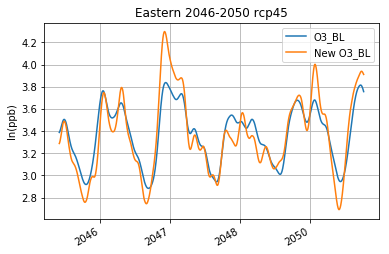

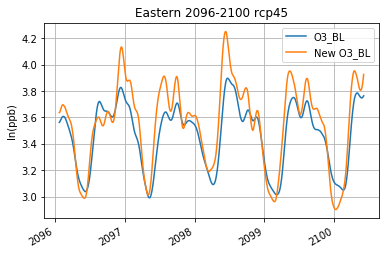

In [23]:
# Testing
test = filelist[0]
test2 = explist[1]
future_regression(test, test2)

Eastern 4382 4382 4382 4382 4382
Regression Coefficients: -52.4818 0.0005 -0.0167 0.0664 0.0908


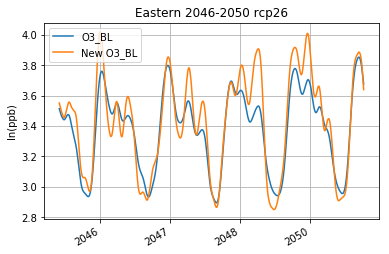

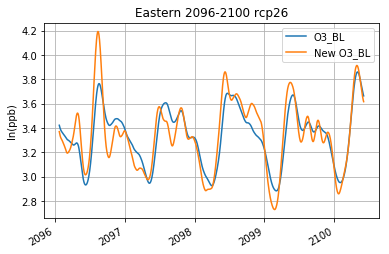

Eastern 4382 4382 4382 4382 4382
Regression Coefficients: -52.4818 0.0005 -0.0167 0.0664 0.0908


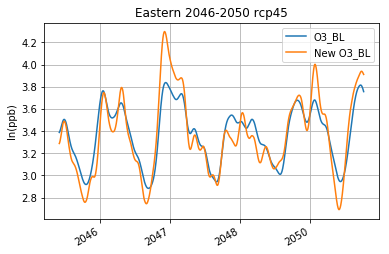

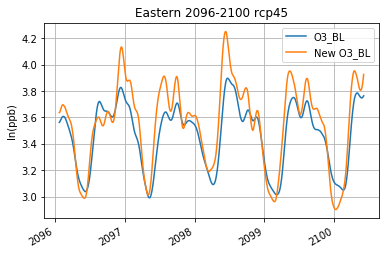

Eastern 4382 4382 4382 4382 4382
Regression Coefficients: -52.4818 0.0005 -0.0167 0.0664 0.0908


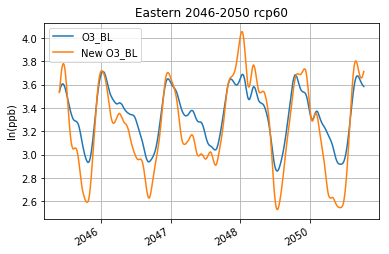

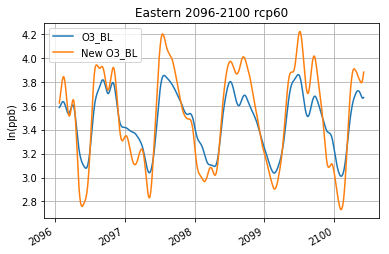

Eastern 4382 4382 4382 4382 4382
Regression Coefficients: -52.4818 0.0005 -0.0167 0.0664 0.0908


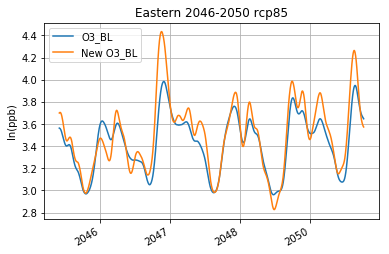

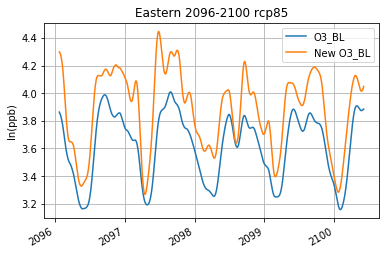

Tsuen Wan 4382 4382 4382 4382 4382
Regression Coefficients: -36.4214 0.0004 -0.0339 0.0488 0.0159


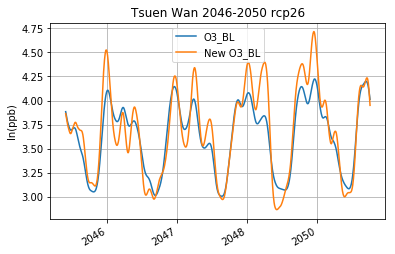

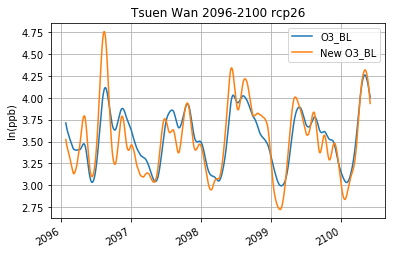

Tsuen Wan 4382 4382 4382 4382 4382
Regression Coefficients: -36.4214 0.0004 -0.0339 0.0488 0.0159


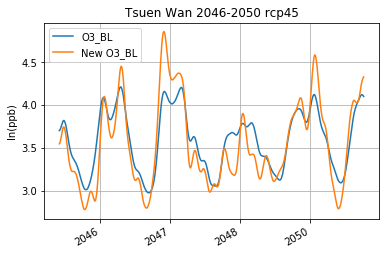

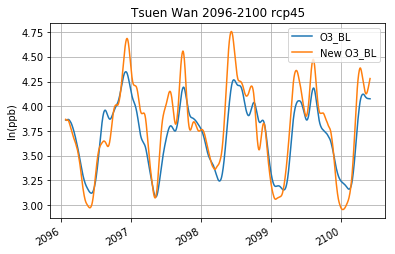

Tsuen Wan 4382 4382 4382 4382 4382
Regression Coefficients: -36.4214 0.0004 -0.0339 0.0488 0.0159


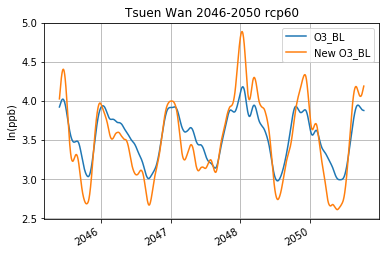

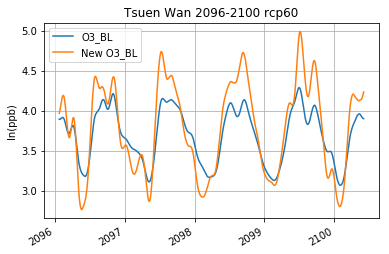

Tsuen Wan 4382 4382 4382 4382 4382
Regression Coefficients: -36.4214 0.0004 -0.0339 0.0488 0.0159


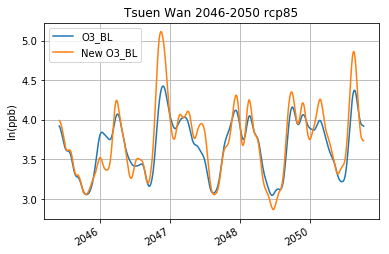

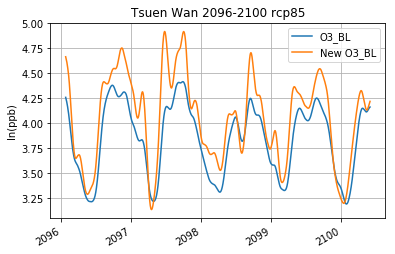

Tung Chung 4382 4382 4382 4382 4382
Regression Coefficients: -55.6366 0.0006 -0.0173 0.0725 -0.0222


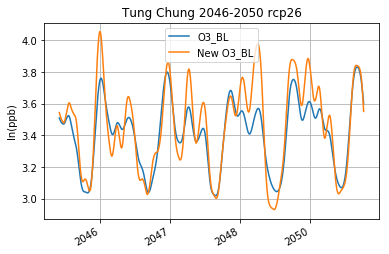

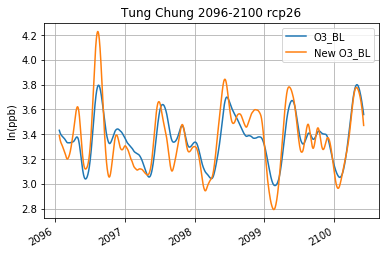

Tung Chung 4382 4382 4382 4382 4382
Regression Coefficients: -55.6366 0.0006 -0.0173 0.0725 -0.0222


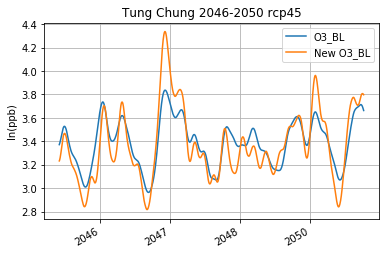

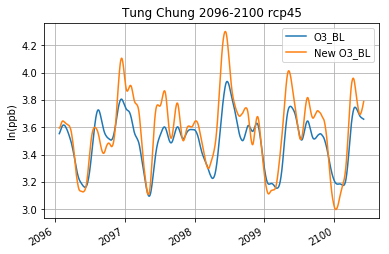

Tung Chung 4382 4382 4382 4382 4382
Regression Coefficients: -55.6366 0.0006 -0.0173 0.0725 -0.0222


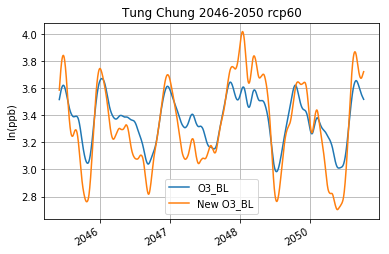

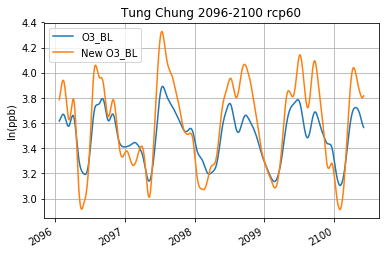

Tung Chung 4382 4382 4382 4382 4382
Regression Coefficients: -55.6366 0.0006 -0.0173 0.0725 -0.0222


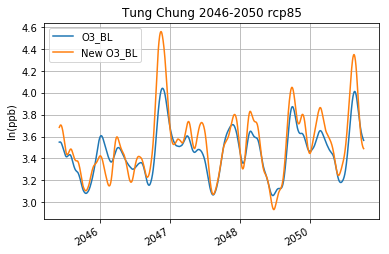

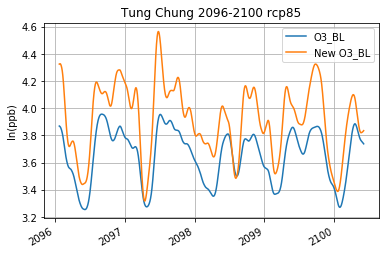

Yuen Long 4382 4382 4382 4382 4382
Regression Coefficients: -55.8416 0.0006 -0.0287 0.0846 -0.0075


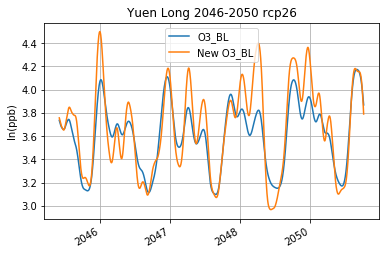

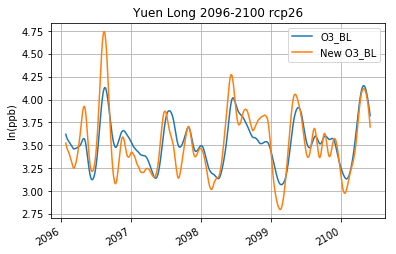

Yuen Long 4382 4382 4382 4382 4382
Regression Coefficients: -55.8416 0.0006 -0.0287 0.0846 -0.0075


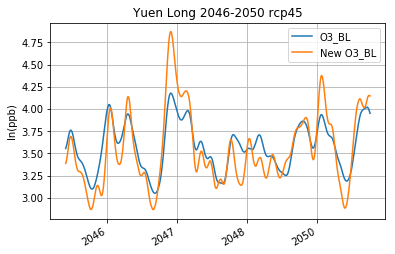

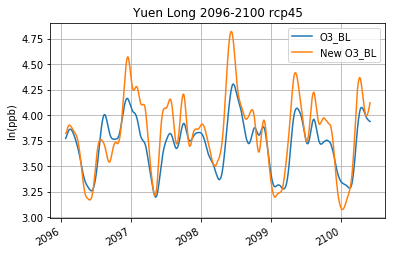

Yuen Long 4382 4382 4382 4382 4382
Regression Coefficients: -55.8416 0.0006 -0.0287 0.0846 -0.0075


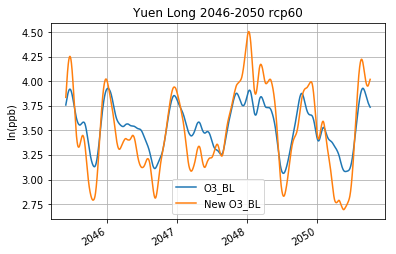

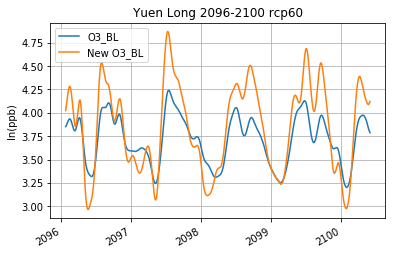

Yuen Long 4382 4382 4382 4382 4382
Regression Coefficients: -55.8416 0.0006 -0.0287 0.0846 -0.0075


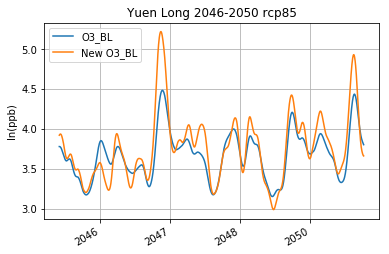

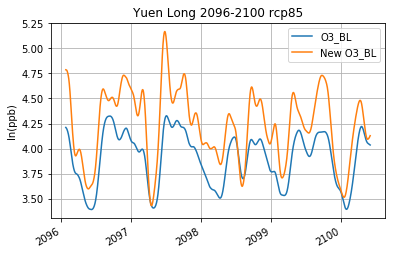

Kwai Chung 4382 4382 4382 4382 4382
Regression Coefficients: -57.7897 0.0006 -0.0303 0.0439 0.0446


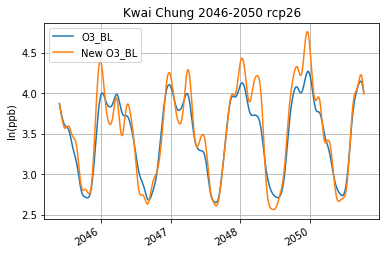

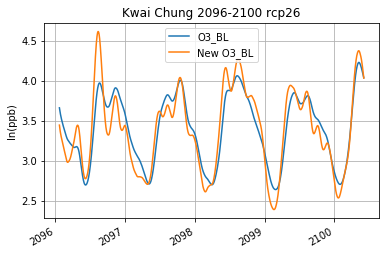

Kwai Chung 4382 4382 4382 4382 4382
Regression Coefficients: -57.7897 0.0006 -0.0303 0.0439 0.0446


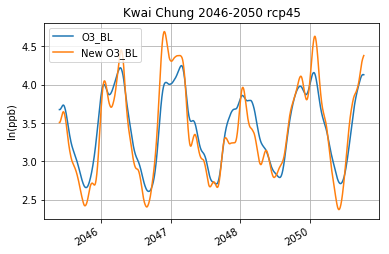

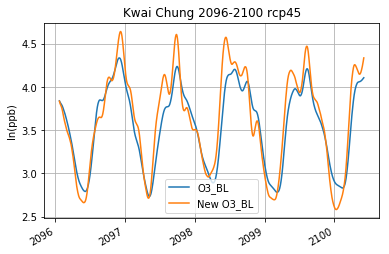

Kwai Chung 4382 4382 4382 4382 4382
Regression Coefficients: -57.7897 0.0006 -0.0303 0.0439 0.0446


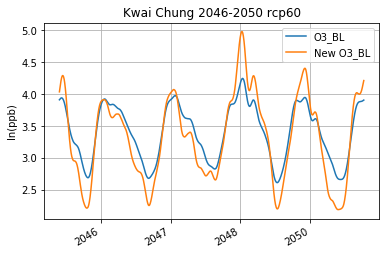

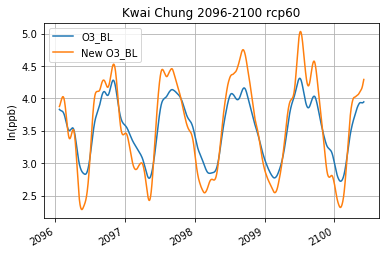

Kwai Chung 4382 4382 4382 4382 4382
Regression Coefficients: -57.7897 0.0006 -0.0303 0.0439 0.0446


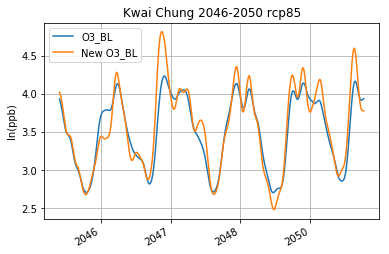

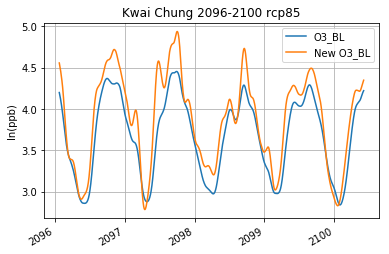

Kwun Tong 4382 4382 4382 4382 4382
Regression Coefficients: -69.5804 0.0007 -0.0251 0.0509 0.2213


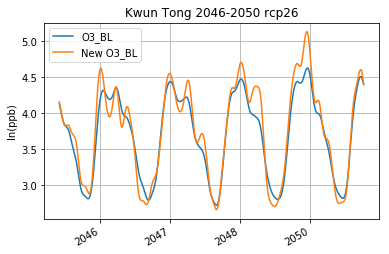

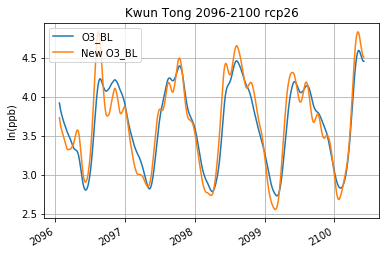

Kwun Tong 4382 4382 4382 4382 4382
Regression Coefficients: -69.5804 0.0007 -0.0251 0.0509 0.2213


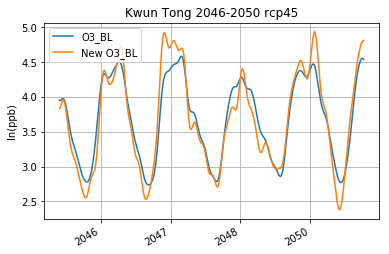

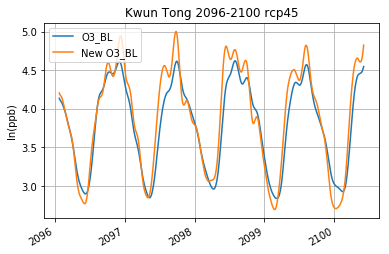

Kwun Tong 4382 4382 4382 4382 4382
Regression Coefficients: -69.5804 0.0007 -0.0251 0.0509 0.2213


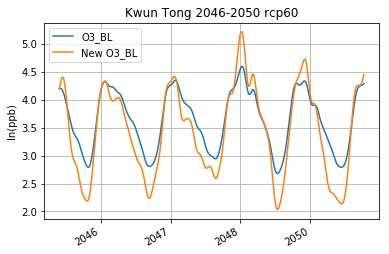

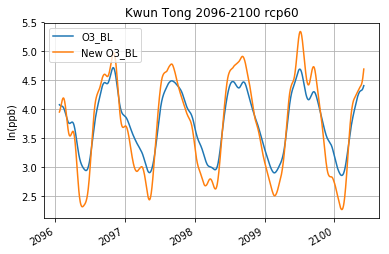

Kwun Tong 4382 4382 4382 4382 4382
Regression Coefficients: -69.5804 0.0007 -0.0251 0.0509 0.2213


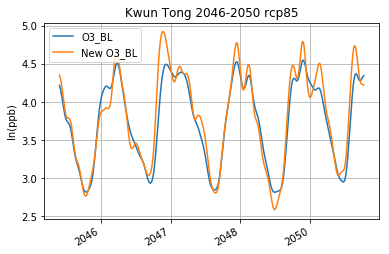

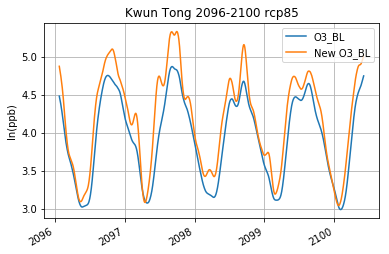

Macau 4382 4382 4382 4382 4382
Regression Coefficients: -7.1446 0.0002 -0.0466 -0.0022 -0.1675


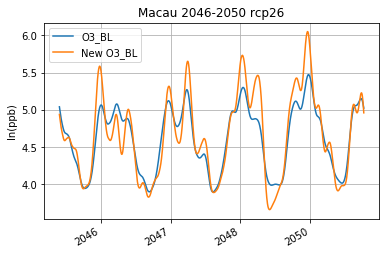

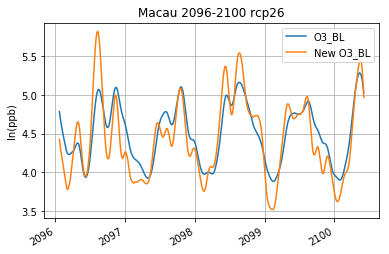

Macau 4382 4382 4382 4382 4382
Regression Coefficients: -7.1446 0.0002 -0.0466 -0.0022 -0.1675


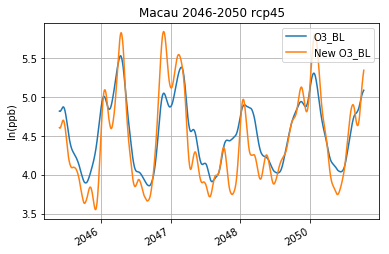

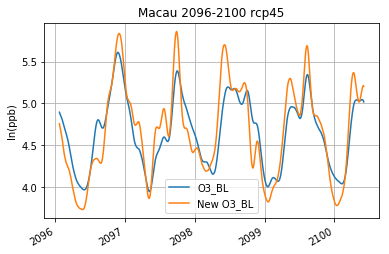

Macau 4382 4382 4382 4382 4382
Regression Coefficients: -7.1446 0.0002 -0.0466 -0.0022 -0.1675


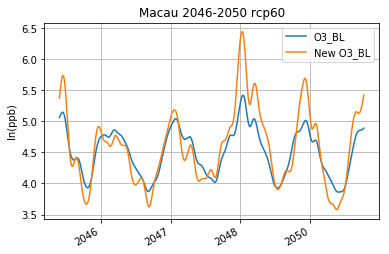

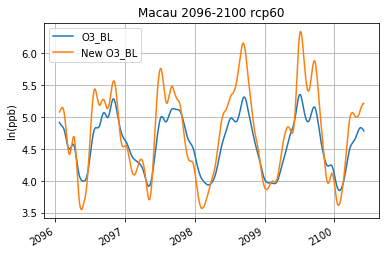

Macau 4382 4382 4382 4382 4382
Regression Coefficients: -7.1446 0.0002 -0.0466 -0.0022 -0.1675


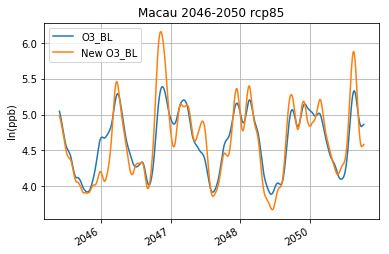

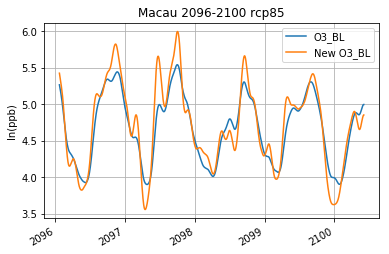

Sha Tin 4382 4382 4382 4382 4382
Regression Coefficients: -20.6177 0.0003 -0.0307 0.0228 -0.1929


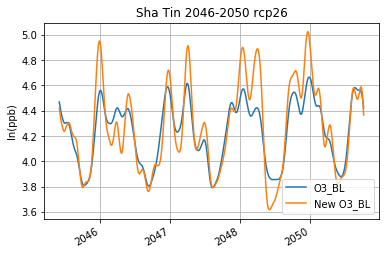

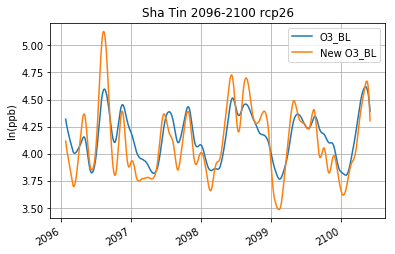

Sha Tin 4382 4382 4382 4382 4382
Regression Coefficients: -20.6177 0.0003 -0.0307 0.0228 -0.1929


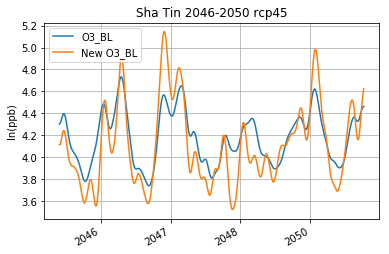

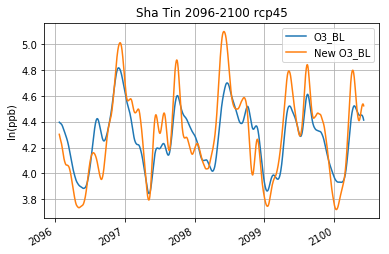

Sha Tin 4382 4382 4382 4382 4382
Regression Coefficients: -20.6177 0.0003 -0.0307 0.0228 -0.1929


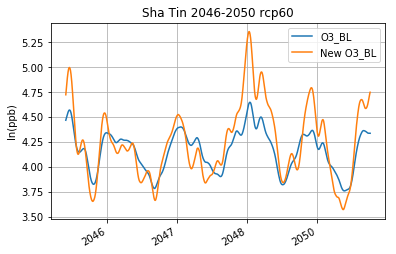

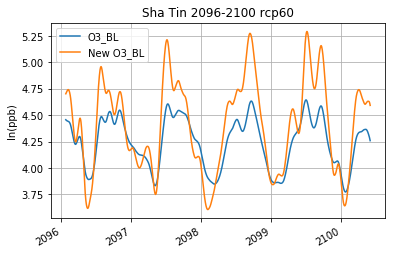

Sha Tin 4382 4382 4382 4382 4382
Regression Coefficients: -20.6177 0.0003 -0.0307 0.0228 -0.1929


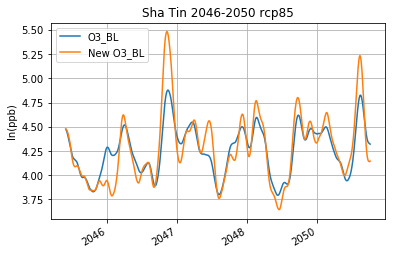

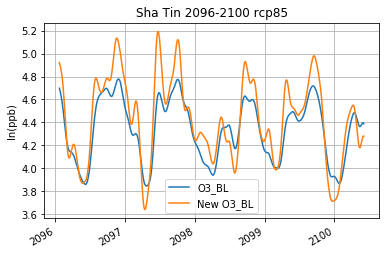

ShamShuiPo 4382 4382 4382 4382 4382
Regression Coefficients: -52.1175 0.0006 -0.0224 0.0602 -0.0047


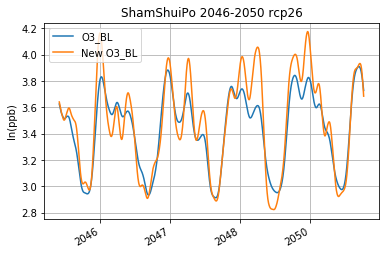

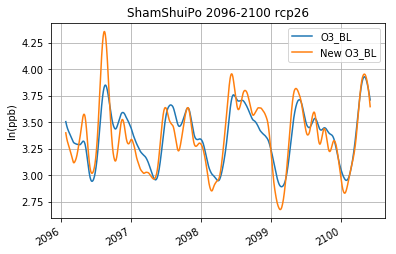

ShamShuiPo 4382 4382 4382 4382 4382
Regression Coefficients: -52.1175 0.0006 -0.0224 0.0602 -0.0047


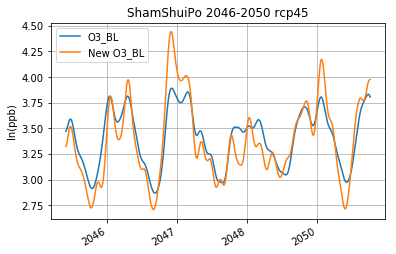

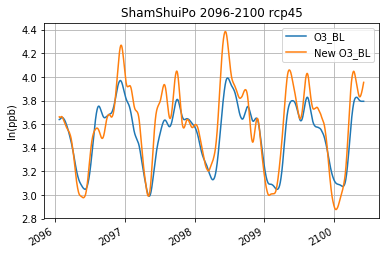

ShamShuiPo 4382 4382 4382 4382 4382
Regression Coefficients: -52.1175 0.0006 -0.0224 0.0602 -0.0047


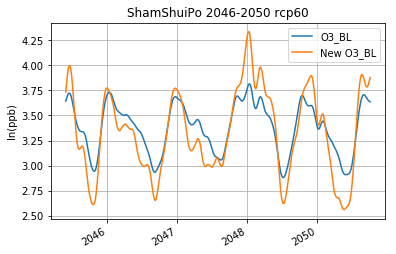

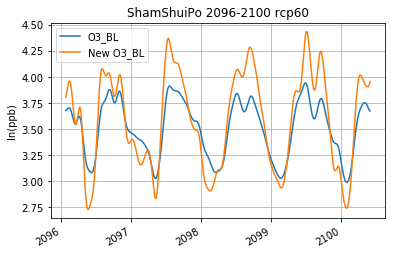

ShamShuiPo 4382 4382 4382 4382 4382
Regression Coefficients: -52.1175 0.0006 -0.0224 0.0602 -0.0047


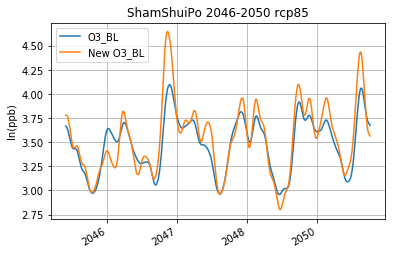

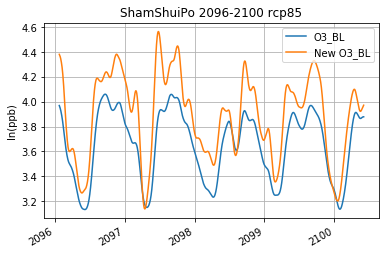

In [24]:
for i in range(len(filelist)):
    for j in range(len(explist)):
        exp = explist[j]
        station = filelist[i]
        future_regression(station, exp)